<a href="https://colab.research.google.com/github/thomaslu678/gee-test/blob/main/clean/7_fetch_met_data_linreg_tif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NOTE: Requires export_clean.csv (cleaned up export CSV with sorts and time columns)

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from datetime import timedelta
import scipy.stats as stats
import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize
import geopandas as gpd
from shapely.geometry import Point
import requests

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read cleaned up export csv

In [3]:
calculations_df = pd.read_csv('/content/drive/MyDrive/Year 2/Fall 2025/HONOR 3700/Data/2/export_clean_calculations.csv')

In [4]:
calculations_df

,point_id,time,LST_C,NDVI,NDBI,NDMI,Albedo
0,2505,1988-12-24 01:43:00,-0.527053,0.008107,-0.042450,0.042450,0.185196
1,2527,1988-12-24 01:43:00,-0.527053,0.008107,-0.105622,0.105622,0.183640
2,2528,1988-12-24 01:43:00,-0.527053,-0.011292,-0.099890,0.099890,0.176036
3,2550,1988-12-24 01:43:00,-0.431348,-0.029073,-0.068238,0.068238,0.171996
4,2551,1988-12-24 01:43:00,-0.431348,0.008107,-0.092413,0.092413,0.181680
...,...,...,...,...,...,...,...
2646549,4618,2026-01-31 02:11:17,1.397293,0.192808,0.070690,-0.070690,0.085628
2646550,4619,2026-01-31 02:11:17,1.356276,0.306176,0.073418,-0.073418,0.127741
2646551,4620,2026-01-31 02:11:17,1.575030,0.157747,-0.135409,0.135409,0.149991
2646552,4627,2026-01-31 02:11:17,1.438309,0.157339,0.031072,-0.031072,0.071202


In [5]:
input_df = pd.read_csv('/content/drive/MyDrive/Year 2/Fall 2025/HONOR 3700/Data/2/points.csv')

In [6]:
input_df

,point_id,long,lat,distance
0,1,126.974400,37.570275,321.262762
1,2,126.974402,37.570005,311.450539
2,3,126.974403,37.569735,304.291166
3,4,126.974405,37.569464,299.974648
4,5,126.974407,37.569194,298.624287
...,...,...,...,...
4623,4624,127.044710,37.572190,309.046080
4624,4625,127.044712,37.571920,308.199775
4625,4626,127.044713,37.571649,310.265569
4626,4627,127.044715,37.571379,315.186207


In [8]:
point_id_1_mask = (input_df['point_id'] == 1)
point_id_1 = input_df[point_id_1_mask]

In [9]:
rep_lat = point_id_1['lat'].mean()
rep_long = point_id_1['long'].mean()

In [10]:
# rep_lat = point_id_1['lat'].iloc[0]
# rep_long = point_id_1['long'].iloc[0]

In [11]:
rep_lat, rep_long

(np.float64(37.57027546), np.float64(126.9743997))

# Fetch met data

In [12]:
calculations_df['time'] = pd.to_datetime(calculations_df['time'])

In [13]:
hours = (
    calculations_df['time']
    .dt.floor('H')
    .drop_duplicates()
    .sort_values()
)

hours_str = hours.dt.strftime('%Y-%m-%dT%H:%M')

/tmp/ipython-input-2803264291.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .dt.floor('H')


In [14]:
hours_str

,time
77212,1984-07-30T01:00
22645,1984-08-08T01:00
24685,1984-09-25T01:00
81720,1984-12-05T01:00
83001,1985-02-07T01:00
...,...
2451905,2025-12-22T02:00
2641777,2025-12-30T02:00
2454231,2026-01-07T02:00
2456046,2026-01-23T02:00


In [15]:
def fetch_open_meteo(lat, lon, start, end):
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": "temperature_2m",
        "start_date": start.strftime('%Y-%m-%d'),
        "end_date": end.strftime('%Y-%m-%d'),
        "timezone": "UTC"
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    return r.json()

In [16]:
temps = []

for year, group in hours.groupby(hours.dt.year):
    start = group.min()
    end   = group.max()

    data = fetch_open_meteo(rep_lat, rep_long, start, end)

    df = pd.DataFrame({
        "hour": pd.to_datetime(data["hourly"]["time"], utc=True),
        "temperature_C": data["hourly"]["temperature_2m"]
    })

    temps.append(df)

hourly_temp = pd.concat(temps).drop_duplicates(subset="hour")

In [17]:
hourly_temp

,hour,temperature_C
0,1984-07-30 00:00:00+00:00,27.3
1,1984-07-30 01:00:00+00:00,28.6
2,1984-07-30 02:00:00+00:00,29.9
3,1984-07-30 03:00:00+00:00,31.0
4,1984-07-30 04:00:00+00:00,32.0
...,...,...
595,2026-01-31 19:00:00+00:00,-6.8
596,2026-01-31 20:00:00+00:00,-7.8
597,2026-01-31 21:00:00+00:00,-8.4
598,2026-01-31 22:00:00+00:00,-8.8


In [18]:
calculations_df['hour'] = calculations_df['time'].dt.floor('H')

calculations_df['hour'] = pd.to_datetime(calculations_df['hour'], utc=True)
hourly_temp['hour'] = pd.to_datetime(hourly_temp['hour'], utc=True)

/tmp/ipython-input-342303639.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  calculations_df['hour'] = calculations_df['time'].dt.floor('H')


In [19]:
calculations_df = calculations_df.merge(
    hourly_temp,
    on='hour',
    how='left'
)

In [20]:
calculations_df['delta_C'] = calculations_df['temperature_C'] - calculations_df['LST_C']

In [21]:
calculations_df

,point_id,time,LST_C,NDVI,NDBI,NDMI,Albedo,hour,temperature_C,delta_C
0,2505,1988-12-24 01:43:00,-0.527053,0.008107,-0.042450,0.042450,0.185196,1988-12-24 01:00:00+00:00,2.6,3.127053
1,2527,1988-12-24 01:43:00,-0.527053,0.008107,-0.105622,0.105622,0.183640,1988-12-24 01:00:00+00:00,2.6,3.127053
2,2528,1988-12-24 01:43:00,-0.527053,-0.011292,-0.099890,0.099890,0.176036,1988-12-24 01:00:00+00:00,2.6,3.127053
3,2550,1988-12-24 01:43:00,-0.431348,-0.029073,-0.068238,0.068238,0.171996,1988-12-24 01:00:00+00:00,2.6,3.031348
4,2551,1988-12-24 01:43:00,-0.431348,0.008107,-0.092413,0.092413,0.181680,1988-12-24 01:00:00+00:00,2.6,3.031348
...,...,...,...,...,...,...,...,...,...,...
2646549,4618,2026-01-31 02:11:17,1.397293,0.192808,0.070690,-0.070690,0.085628,2026-01-31 02:00:00+00:00,-5.6,-6.997293
2646550,4619,2026-01-31 02:11:17,1.356276,0.306176,0.073418,-0.073418,0.127741,2026-01-31 02:00:00+00:00,-5.6,-6.956276
2646551,4620,2026-01-31 02:11:17,1.575030,0.157747,-0.135409,0.135409,0.149991,2026-01-31 02:00:00+00:00,-5.6,-7.175030
2646552,4627,2026-01-31 02:11:17,1.438309,0.157339,0.031072,-0.031072,0.071202,2026-01-31 02:00:00+00:00,-5.6,-7.038309


In [22]:
print(calculations_df['time'].unique())

<DatetimeArray>
['1988-12-24 01:43:00', '1989-02-26 01:43:56', '1989-03-14 01:43:50',
 '1989-05-17 01:44:21', '1989-08-05 01:44:33', '1991-11-15 01:21:41',
 '1991-12-01 01:20:53', '1984-08-08 01:34:24', '1984-09-25 01:34:59',
 '1986-06-11 01:28:45',
 ...
 '2025-06-05 02:10:27', '2025-07-23 02:10:54', '2025-08-08 02:11:03',
 '2025-08-24 02:11:10', '2025-10-27 02:11:21', '2025-11-12 02:11:26',
 '2025-11-28 02:11:24', '2025-12-14 02:11:24', '2025-12-30 02:11:28',
 '2026-01-31 02:11:17']
Length: 970, dtype: datetime64[ns]


In [23]:
input_df

,point_id,long,lat,distance
0,1,126.974400,37.570275,321.262762
1,2,126.974402,37.570005,311.450539
2,3,126.974403,37.569735,304.291166
3,4,126.974405,37.569464,299.974648
4,5,126.974407,37.569194,298.624287
...,...,...,...,...
4623,4624,127.044710,37.572190,309.046080
4624,4625,127.044712,37.571920,308.199775
4625,4626,127.044713,37.571649,310.265569
4626,4627,127.044715,37.571379,315.186207


# Fetch data for only one point in calculations_df


In [ ]:
start = '2020-02-26'
end = '2025-02-26'
point_id_167_mask_calculations = (calculations_df['point_id'] == 167) & (calculations_df['time'] >= start) & (calculations_df['time'] <= end) & (calculations_df['delta_C'] < 10)
# point_id_167_mask_calculations = (calculations_df['point_id'] == 167)
point_id_167_calculations = calculations_df[point_id_167_mask_calculations]

In [ ]:
point_id_167_calculations

,point_id,time,LST_C,NDVI,NDBI,NDMI,Albedo,hour,temperature_C,delta_C
949696,167,2020-11-07 01:27:19,16.962956,0.031482,-0.088552,0.088552,0.083439,2020-11-07 01:00:00+00:00,13.6,-3.362956
955215,167,2020-12-25 01:23:50,0.334288,-0.045623,0.270097,-0.270097,0.035400,2020-12-25 01:00:00+00:00,-2.8,-3.134288
956802,167,2021-01-10 01:22:43,-9.642912,-0.013038,-0.533412,0.533412,0.024034,2021-01-10 01:00:00+00:00,-10.2,-0.557088
959269,167,2021-02-27 01:19:11,8.291439,-0.038345,0.007970,-0.007970,0.029764,2021-02-27 01:00:00+00:00,7.2,-1.091439
964553,167,2021-06-19 01:09:57,32.056932,0.311103,-0.142825,0.142825,0.106089,2021-06-19 01:00:00+00:00,20.4,-11.656932
...,...,...,...,...,...,...,...,...,...,...
2588120,167,2024-10-08 02:10:56,23.481120,0.311890,-0.209254,0.209254,0.040376,2024-10-08 02:00:00+00:00,18.2,-5.281120
2592744,167,2024-10-24 02:11:13,18.436122,0.385408,-0.182893,0.182893,0.041243,2024-10-24 02:00:00+00:00,13.1,-5.336122
2597285,167,2024-11-09 02:11:08,16.949284,0.289742,-0.130289,0.130289,0.039168,2024-11-09 02:00:00+00:00,13.2,-3.749284
2605791,167,2024-12-27 02:11:13,-0.561233,0.130791,-0.031067,0.031067,0.017026,2024-12-27 02:00:00+00:00,-2.8,-2.238767


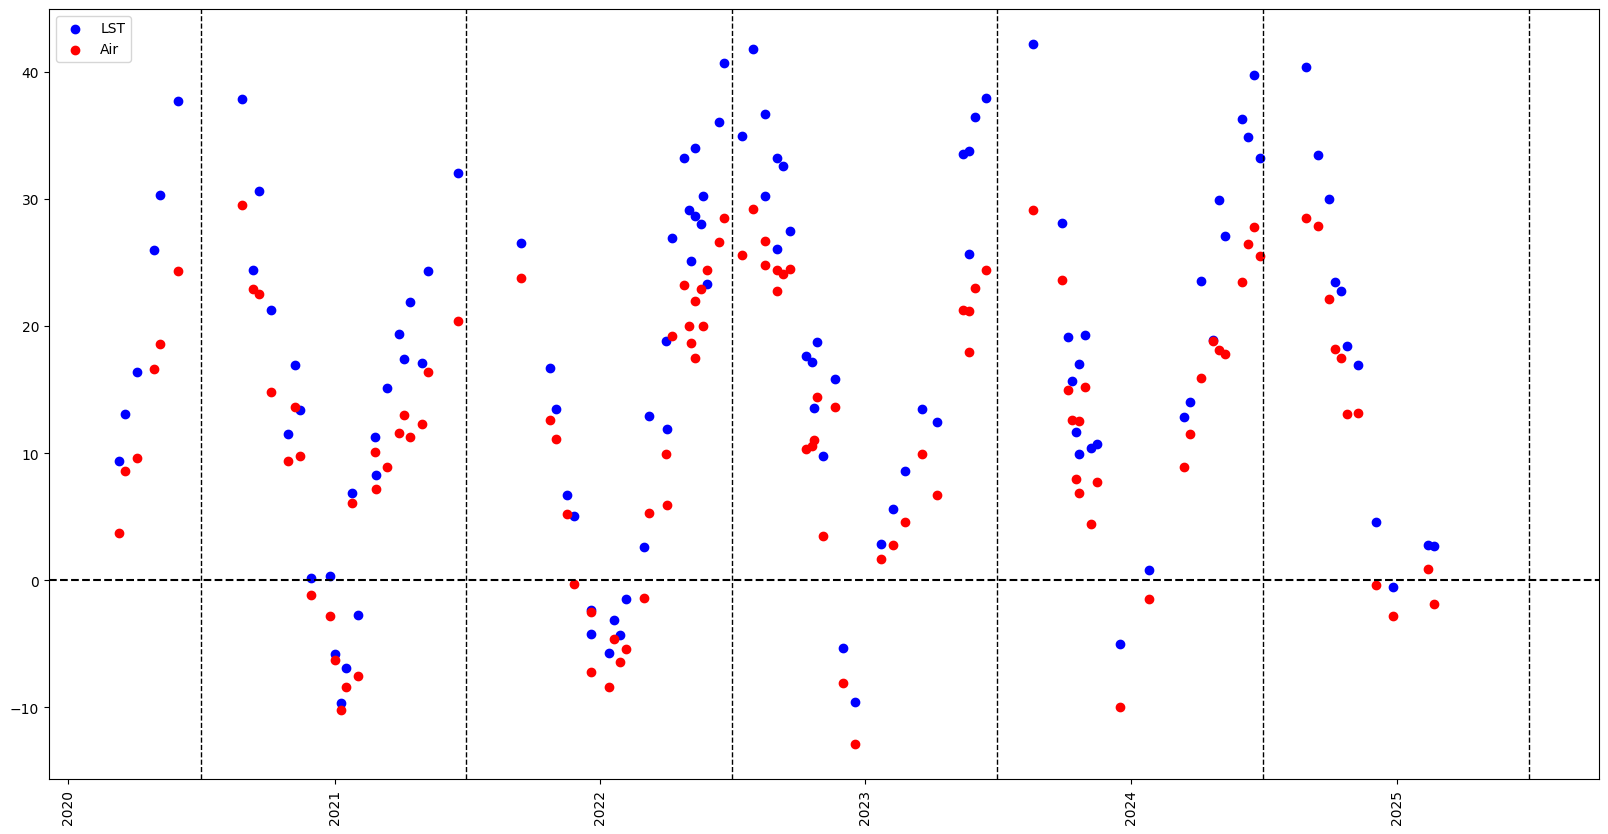

In [ ]:
plt.figure(figsize=(20, 10))
# plt.scatter(point_id_167_calculations['time'], point_id_167_calculations['delta_C'], color='purple', label='Delta')
plt.scatter(point_id_167_calculations['time'], point_id_167_calculations['LST_C'], color='blue', label='LST')
plt.scatter(point_id_167_calculations['time'], point_id_167_calculations['temperature_C'], color='red', label='Air')

years = point_id_167_calculations['time'].dt.year.unique()
for year in years:
    plt.axvline(pd.to_datetime(f'{year}-07-01'), color='black', linestyle='--', lw=1)

plt.axhline(y=0, color='black', linestyle='--')

plt.legend()
plt.xticks(rotation='vertical')
plt.show()

# Fit linear regression

In [24]:
seconds_per_year = 365.2425 * 24 * 3600

calculations_df['time_years'] = (
    calculations_df['time'].astype('int64') / 1e9
) / seconds_per_year

In [25]:
def compute_slope(group):
    # Need at least 2 points to fit a line
    if len(group) < 2:
        return np.nan

    x = group['time_years'].values
    y = group['delta_C'].values

    m, b = np.polyfit(x, y, 1)
    return m

In [26]:
point_id_167_calculations

NameError: name 'point_id_167_calculations' is not defined

In [27]:
m_df = (
    calculations_df
    .groupby('point_id', as_index=False)
    .apply(compute_slope)
    .rename(columns={None: 'm'})
)

/tmp/ipython-input-3052817466.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_slope)


In [28]:
input_df = input_df.merge(
    m_df,
    on='point_id',
    how='left'
)

In [29]:
input_df

,point_id,long,lat,distance,m
0,1,126.974400,37.570275,321.262762,0.065098
1,2,126.974402,37.570005,311.450539,0.063412
2,3,126.974403,37.569735,304.291166,0.037558
3,4,126.974405,37.569464,299.974648,0.023624
4,5,126.974407,37.569194,298.624287,0.008761
...,...,...,...,...,...
4623,4624,127.044710,37.572190,309.046080,0.037662
4624,4625,127.044712,37.571920,308.199775,0.007901
4625,4626,127.044713,37.571649,310.265569,-0.023929
4626,4627,127.044715,37.571379,315.186207,-0.026201


# Export to .tif

In [30]:
input_df['m'] = pd.to_numeric(input_df['m'], errors='coerce')

In [31]:
gdf = gpd.GeoDataFrame(
    input_df,
    geometry=gpd.points_from_xy(
        input_df['long'],
        input_df['lat']
    ),
    crs="EPSG:4326"
)

gdf_5179 = gdf.to_crs("EPSG:5179")

In [32]:
gdf_5179['m'].isna().sum()

np.int64(0)

In [33]:
pixel_size = 30

xs = gdf_5179.geometry.x.values
ys = gdf_5179.geometry.y.values

xmin = xs.min() - pixel_size / 2
ymax = ys.max() + pixel_size / 2

width = int((xs.max() - xs.min()) / pixel_size) + 1
height = int((ys.max() - ys.min()) / pixel_size) + 1

transform = from_origin(
    xmin,
    ymax,
    pixel_size,
    pixel_size
)

In [34]:
shapes = (
    (geom, value)
    for geom, value in zip(gdf_5179.geometry, gdf_5179['m'])
)

raster = rasterize(
    shapes=shapes,
    out_shape=(height, width),
    transform=transform,
    fill=np.nan,
    dtype="float32"
)

In [35]:
path = "/content/sample_data/input_df_m.tif"

with rasterio.open(
    path,
    "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,
    dtype="float32",
    crs="EPSG:5179",
    transform=transform,
    nodata=np.nan
) as dst:
    dst.write(raster, 1)

# Get final dataset

In [ ]:
merged_df = pd.merge(calculations_df, input_df, on="point_id")

In [ ]:
merged_df['hour_of_day'] = merged_df['time'].dt.hour

In [ ]:
merged_df['month'] = merged_df['time'].dt.month

In [ ]:
merged_df

,point_id,time,LST_C,NDVI,NDBI,NDMI,Albedo,hour,temperature_C,delta_C,time_num,time_years,long,lat,distance,m,hour_of_day,month
0,2505,1988-12-24 01:43:00+00:00,-0.527053,0.008107,-0.042450,0.042450,0.185196,1988-12-24 01:00:00+00:00,2.7,3.227053,5.989310e+08,18.979367,127.013452,37.572606,317.553292,-0.029627,1,12
1,2527,1988-12-24 01:43:00+00:00,-0.527053,0.008107,-0.105622,0.105622,0.183640,1988-12-24 01:00:00+00:00,2.7,3.227053,5.989310e+08,18.979367,127.013792,37.572608,317.478476,-0.003934,1,12
2,2528,1988-12-24 01:43:00+00:00,-0.527053,-0.011292,-0.099890,0.099890,0.176036,1988-12-24 01:00:00+00:00,2.7,3.227053,5.989310e+08,18.979367,127.013794,37.572337,287.478569,-0.007349,1,12
3,2550,1988-12-24 01:43:00+00:00,-0.431348,-0.029073,-0.068238,0.068238,0.171996,1988-12-24 01:00:00+00:00,2.7,3.131348,5.989310e+08,18.979367,127.014133,37.572339,287.403753,-0.007378,1,12
4,2551,1988-12-24 01:43:00+00:00,-0.431348,0.008107,-0.092413,0.092413,0.181680,1988-12-24 01:00:00+00:00,2.7,3.131348,5.989310e+08,18.979367,127.014135,37.572068,257.403847,-0.019299,1,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2646549,4618,2026-01-31 02:11:17+00:00,1.397293,0.192808,0.070690,-0.070690,0.085628,2026-01-31 02:00:00+00:00,-5.6,-6.997293,1.769825e+09,56.083537,127.044375,37.571377,285.926939,-0.037815,2,1
2646550,4619,2026-01-31 02:11:17+00:00,1.356276,0.306176,0.073418,-0.073418,0.127741,2026-01-31 02:00:00+00:00,-5.6,-6.956276,1.769825e+09,56.083537,127.044377,37.571107,294.332867,-0.026298,2,1
2646551,4620,2026-01-31 02:11:17+00:00,1.575030,0.157747,-0.135409,0.135409,0.149991,2026-01-31 02:00:00+00:00,-5.6,-7.175030,1.769825e+09,56.083537,127.044379,37.570837,305.465969,-0.020183,2,1
2646552,4627,2026-01-31 02:11:17+00:00,1.438309,0.157339,0.031072,-0.031072,0.071202,2026-01-31 02:00:00+00:00,-5.6,-7.038309,1.769825e+09,56.083537,127.044715,37.571379,315.186207,-0.031023,2,1


In [ ]:
merged_df.columns

Index(['point_id', 'time', 'LST_C', 'NDVI', 'NDBI', 'NDMI', 'Albedo', 'hour',
       'temperature_C', 'delta_C', 'time_num', 'time_years', 'long', 'lat',
       'distance', 'm', 'hour_of_day', 'month'],
      dtype='object')

In [ ]:
columns = ['NDVI', 'NDBI', 'NDMI', 'Albedo', 'time_years', 'long', 'lat',
       'distance', 'hour_of_day', 'month', 'm']

In [ ]:
export_df = merged_df[columns]

In [ ]:
export_df

,NDVI,NDBI,NDMI,Albedo,time_years,long,lat,distance,hour_of_day,month,m
0,0.008107,-0.042450,0.042450,0.185196,18.979367,127.013452,37.572606,317.553292,1,12,-0.029627
1,0.008107,-0.105622,0.105622,0.183640,18.979367,127.013792,37.572608,317.478476,1,12,-0.003934
2,-0.011292,-0.099890,0.099890,0.176036,18.979367,127.013794,37.572337,287.478569,1,12,-0.007349
3,-0.029073,-0.068238,0.068238,0.171996,18.979367,127.014133,37.572339,287.403753,1,12,-0.007378
4,0.008107,-0.092413,0.092413,0.181680,18.979367,127.014135,37.572068,257.403847,1,12,-0.019299
...,...,...,...,...,...,...,...,...,...,...,...
2646549,0.192808,0.070690,-0.070690,0.085628,56.083537,127.044375,37.571377,285.926939,2,1,-0.037815
2646550,0.306176,0.073418,-0.073418,0.127741,56.083537,127.044377,37.571107,294.332867,2,1,-0.026298
2646551,0.157747,-0.135409,0.135409,0.149991,56.083537,127.044379,37.570837,305.465969,2,1,-0.020183
2646552,0.157339,0.031072,-0.031072,0.071202,56.083537,127.044715,37.571379,315.186207,2,1,-0.031023


In [ ]:
export_df.columns

Index(['NDVI', 'NDBI', 'NDMI', 'Albedo', 'time_years', 'long', 'lat',
       'distance', 'hour_of_day', 'month', 'm'],
      dtype='object')

In [ ]:
export_df.to_csv('dataset.csv', index=False)